# Tensorflow training  
Es ist zu vermuten, dass ein Neuronales Netz, das auf das Erkennen von Plakaten trainiert worden ist zu sinnigeren Clustern kommt. Von daher soll mittels dieses Notebooks ein Neuronales Netz auf einen Trainingsdatensatz trainiert werden.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, time
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import Sequential
from keras.models import Model

In [36]:
WORK_DIR = "/home/julius/PowerFolders/Masterarbeit/"
os.chdir(WORK_DIR)

DATASET_PATH = "./1_Datensaetze/tensorflow"
OUTPUT_PATH = "./trained_models/tensorflow/"

Nach den Imports und dem Verweis auf den Speicherort des Datensatzes wird dieser mittels der _image_dataset_from_directory_ Funktion importiert. Da der Datensatz in keine Untergliederung in Training und Validation hat, wird der Funktion die entsprechenden Parameter mitgegeben. Gleichzeitig wird die Größe der Bilder und die Größer ihrer Batches, also die Größe der Bündel, in die sie eingeteilt werden, definiert.

In [4]:
train_dataset = image_dataset_from_directory(DATASET_PATH, validation_split=0.25, subset="training", seed=123, image_size=(160, 160), batch_size=25)
validation_dataset = image_dataset_from_directory(DATASET_PATH, validation_split=0.25, subset="validation", seed=123, image_size=(160, 160), batch_size=25)

Found 800 files belonging to 8 classes.
Using 600 files for training.
Found 800 files belonging to 8 classes.
Using 200 files for validation.


In [5]:
class_names = train_dataset.class_names

Wie eine Stichprobe eines Batches zeigt, scheinen sowohl die Bilder als auch die Kategorien korrekt eingelesen zu sein.

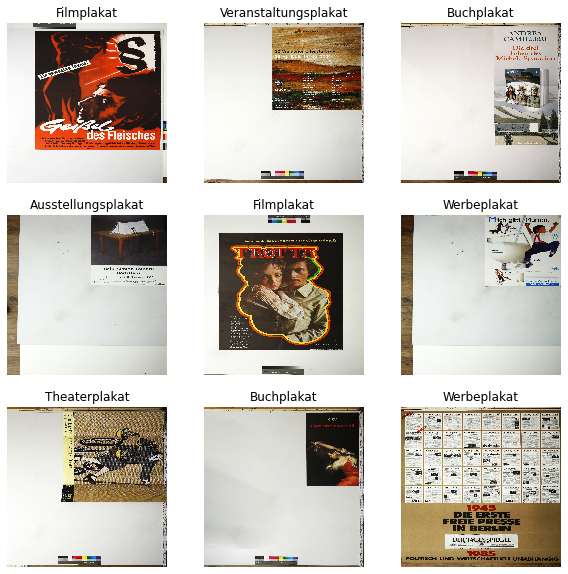

In [6]:
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Neben der Gliederung in Training und Validations Daten soll auch eine Unterteilung in Testdaten geschehen. Hierzu werden die Batches des Validationsdatensatzes in zwei Hälften geteilt und dem Datensatz zur Validierung zugesprochen

In [7]:
validation_batchs = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_batchs//2)
validation_dataset = validation_dataset.skip(validation_batchs//2)

In [8]:
print("Number of validation batches: {}".format(tf.data.experimental.cardinality(validation_dataset)))
print("Number of test batches: {}".format(tf.data.experimental.cardinality(test_dataset)))

Number of validation batches: 4
Number of test batches: 4


Für eine schnellere Prozesierung der Daten werden die drei Sets geprefetched und zusätzlich im Cache gespeichert. Das Trainingsset wird zudem durch die Shuffel Methode gemischt.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(600).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Nach dem laden der Daten muss das Modell gebaut werden. Hierzu werden in den folgenden Codeblöcken einzelne Funktionalitäten implementiert. Durch den _data_augemntation_ Layer werden die Bilder bevor sie an das Modell gegeben werden horizontal gespiegel oder um 20 Grad gedreht. Dies ist vor allem dann nützlich, wenn wie im Fall der Bayreuther Plakatsammlung nur wenige Daten zum Trainieren vorhanden sind.

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

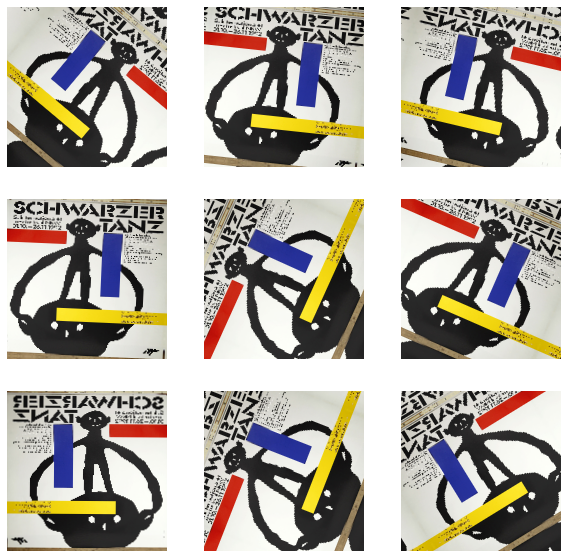

In [11]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/255)
        plt.axis("off")

Bevor die Daten dann an das eigentliche Modell gegeben werden können, müssen sie vorprozessiert werden. Dies passiert im _preprocess_input_ Layer, der die eingebaute Funktion dafür nutzt. Zusätzlich wird auch ein Layer für die Noramlisierung der Daten erstellt. Die RGB Werte der Bilder liegen standardmäßig in eibem Spektrum von 0 bis 255 vor. Für neuronale Netze ist es günstig, wenn die Werte des Inputs klein sind. Daher wird im _normalization_layer_ ein Keras rescaling Layer benutzt.

In [12]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [13]:
normalization_layer = Rescaling(1./255)

'train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))\nimage_batch, labels_batch = next(iter(train_dataset))\nfirst_image = image_batch[0]'

Im folgenden wird nun das Modell geladen. Wie schon bei der Featureextraktion wird der Teil des Modells, der die Klassifizierung vornimmt nicht geladen. Genutzt werden Gewichte, die mit imagenet trainiert wurden. Da dieser Teil des Modells nicht trainiert werden soll, wird das Modell sozusagen eingefroren.

In [14]:
base_model = tf.keras.applications.ResNet50(input_shape=(160, 160, 3), include_top=False, weights="imagenet")
base_model.trainable=False

Der _global_average_ Layer ist der erste Layer im neu zu schreibenden Kopf des Modells. Hier werden die extrahierten Features von der Shape (25, 5, 5, 2048) in die Shape (25, 2048) gebracht. Dies dient dazu, aus den mehrdimensionalen Features einzelne Werte zu machen, die in Predictions gewandelt werden können.

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(25, 5, 5, 2048)
(25, 2048)


Der abschließende _prediction_layer_ besitzt so viele Neuronen, wie es Kategorien gibt, damit für jede auch ein Wert zurückgegeben wird.

In [16]:
prediction_layer = tf.keras.layers.Dense(8)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(25, 8)


Alle vorher beschrieben Layer werden mit dem folgenden Codeblock zu einem Modell zusammen gesetzt.

In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
X = normalization_layer(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Bevor das Training begonnen werden kann muss das Modell noch kompiliert werden. Hierbei wird ein _Optimizer_ und eine _Loss-Funktion_ bestimmt. Als _Optimizer_ wird die Adam Funktion verwendet. Die _learning_rate_ wird auf 0.0001 gesetzt. Dieser Wert wird von tesnorflow als _hyperparameter_ bennant. Als solcher ist er variabel und kann zu unterschiedlichen Ergebnissen führen. Das Setzen eines solchen _hyperparameter_ geschieht durch Erfahrung und Erprobung unterschiedlicher Werte. Das Loss wird über die _SparseCategoricalCrossentropy_ ermittelt. Diese Funktion wird dann genommen, wenn mehrere Label zu ermitteln sind und berechnet das Loss über jedes Label und seine Prediction.

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [19]:
model.evaluate(test_dataset)

4/4 [==============================] - 11s 616ms/step - loss: 2.8456 - accuracy: 0.0813


Nach einer ersten Evaluation des Modells ergibt sich ein hohes Loss von 2.8456 und eine Genauigkeit von 0.0813. Beides sind keine guten Werte. Durch das Training des Modells sollten sich diese Werte verbessern lassen. Für das Training muss ein weiterer _hyperparameter_ gesetzt werden. Mit der Anzahl der Epochen wird bestimmt, wie häufig über den Trainingsdatensatz iteriert wird. Da im Validierungsdatensatz genau 100 Bilder sind entspricht die _accuracy_ der Anzahl der korrekt erkannten Bilder mal 100. 

In [20]:
initial_epochs = 10
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
24/24 [==============================] - 21s 783ms/step - loss: 3.1519 - accuracy: 0.1150 - val_loss: 2.9460 - val_accuracy: 0.1000
Epoch 2/10
24/24 [==============================] - 16s 682ms/step - loss: 2.8115 - accuracy: 0.1200 - val_loss: 3.0439 - val_accuracy: 0.0900
Epoch 3/10
24/24 [==============================] - 16s 679ms/step - loss: 2.6075 - accuracy: 0.1533 - val_loss: 2.9383 - val_accuracy: 0.1000
Epoch 4/10
24/24 [==============================] - 16s 682ms/step - loss: 2.4639 - accuracy: 0.1717 - val_loss: 2.8192 - val_accuracy: 0.1100
Epoch 5/10
24/24 [==============================] - 16s 690ms/step - loss: 2.3901 - accuracy: 0.1933 - val_loss: 2.7305 - val_accuracy: 0.0800
Epoch 6/10
24/24 [==============================] - 16s 690ms/step - loss: 2.2958 - accuracy: 0.2133 - val_loss: 2.6768 - val_accuracy: 0.1400
Epoch 7/10
24/24 [==============================] - 16s 684ms/step - loss: 2.1866 - accuracy: 0.2667 - val_loss: 2.5720 - val_accuracy: 0.1400

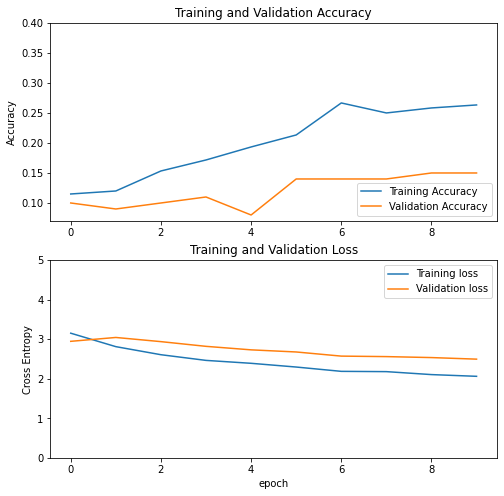

In [21]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 0.4])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 5.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

Wie an den Graphen zu _Loss_ und _Accuracy_ abzulesen ist, steigt die _Accuracy_ im Training stärker als die bei der Validation. Das gleiche ist im sinkenden Verlauf auch für das _Loss_ festzustellen. Beides ist ein Hinweis darauf, dass das Modell schon ab der ersten Epoche beginnt zu _overfitten_. Bei diesem Ereignis lernt das Modell den Trainingsdatensatz, jedoch nicht die Abstraktion der Objektkategorien. Daher ist es auf einem Datensatz, auf dem es nicht trainiert worden ist, nicht im gleichen Maß zuverlässig. Der nun folgende Schritt des _Fine Tuning_ wird diesen Trend noch verstärken. Beim _Fine Tuning_ werden einzelne Schichten des Grundmodells aufgetaut. Hierzu wird zunächst wird die Anzahl der Schichten des Modells ermittelt und dann ab einer gewählten Schicht das Modell trainierbar gemacht.

In [22]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [28]:
base_model.trainable = True
fine_tune_at = 150
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Anschließend wird das Modell erneut Kompiliert.

In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10), metrics=["accuracy"])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

Wie in der Modellübersicht zu sehen ist, sind nun knapp die Hälfte der Parameter wieder trainierbar. Für das Fine Tuning wird an der letzten Epoche des vorherigen Trainings angesetzt. 

In [31]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 10/20
24/24 [==============================] - 28s 1s/step - loss: 2.0185 - accuracy: 0.2854 - val_loss: 2.2530 - val_accuracy: 0.1500
Epoch 11/20
24/24 [==============================] - 25s 1s/step - loss: 1.7541 - accuracy: 0.3587 - val_loss: 2.1958 - val_accuracy: 0.1800
Epoch 12/20
24/24 [==============================] - 25s 1s/step - loss: 1.7364 - accuracy: 0.3695 - val_loss: 2.1624 - val_accuracy: 0.2000
Epoch 13/20
24/24 [==============================] - 25s 1s/step - loss: 1.6752 - accuracy: 0.4021 - val_loss: 2.1245 - val_accuracy: 0.2300
Epoch 14/20
24/24 [==============================] - 25s 1s/step - loss: 1.6737 - accuracy: 0.3709 - val_loss: 2.1555 - val_accuracy: 0.2300
Epoch 15/20
24/24 [==============================] - 25s 1s/step - loss: 1.5621 - accuracy: 0.4495 - val_loss: 2.1772 - val_accuracy: 0.2500
Epoch 16/20
24/24 [==============================] - 25s 1s/step - loss: 1.4805 - accuracy: 0.4476 - val_loss: 2.1165 - val_accuracy: 0.2600
Epoch 17/20
2

In [32]:
acc += history_fine.history["accuracy"]
val_acc += history_fine.history["val_accuracy"]

loss += history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]

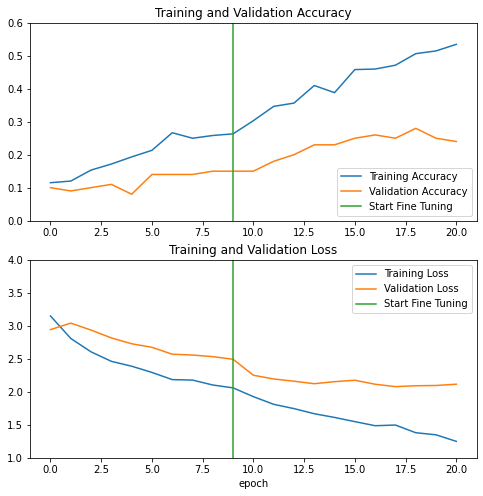

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.ylim([0, 0.6])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([1.0, 4.0])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

Das _Fine Tuning_ führt wie zu erwarten war die Tendenz fort. Jedoch stagniert der _Accuracy_ Wert für die Validation nicht, sondern kann weiter erhöht werden. 

In [34]:
model.evaluate(test_dataset)

4/4 [==============================] - 4s 593ms/step - loss: 2.0255 - accuracy: 0.2300


[2.0255072116851807, 0.23000000417232513]

Wie eine erneute Evaluation des Models nach Training und _Fine Tuning_ zeigt, wurde das Loss von 2.8456 auf 2.0255 veringert werden und auch die Genauigkeit wurde von 0.0813 auf 0.23 gesteigert. Ein kleiner Lernerfolg ist damit festzustellen.  
Um das trainierte Netzwerk weiter zu nutzen müssen die Gewichte exportiert werden. Hierbei ist wichtig, dass im Cluster Prozess lediglich das Grundmodell des ResNet50 verwendet wird. Daher wird ein neues Modell geschaffen, dass mit der Konfigruation des ResNet50 und den Werten des trainierten Modells zusammengesetzt wird. Anschließend werden die Gewichte aus diesem ResNet50 gespeichert. Wichtig ist hierbei auch, dass das Netzwerk trotz _overfitting_ noch das _Fine Tuning_ durchlaufen hat. So haben sich überhaupt Parameter ändern können, die nun exportiert und beim Clustering erneut genutzt werden können. 

In [38]:
output_model = Model(inputs=base_model.inputs, outputs=model.layers[-4].output)
output_model.save_weights("{}Checkpoint-{}".format(output_path, time.strftime("%d,%m,%Y-%H,%M,%S")))